## Import Libraries

In [1]:
#importing liabraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import xml.etree.ElementTree as ET
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
plt.style.use('seaborn')

## Dataset

In [2]:
def get_data(url):
    '''Convert data fetched from API into pandas dataframe'''
    
    #API requests
    r = requests.get(url)
    #Parsing XML
    root = ET.fromstring(r.content)
    
    file_name = []
    for child in root:
        for item in child:
            if 'earthquake-damage-dataset' in item.text:
                file_name.append(item.text)
                
    testing_data = pd.read_csv(url+'/'+file_name[0])
    training_labels = pd.read_csv(url+'/'+file_name[1])
    training_data = pd.read_csv(url+'/'+file_name[2])
    
    return training_data, training_labels, testing_data

url = 'http://storage.googleapis.com/b21-cap0155-capstone-project-bucket-1'

train, labels, test = get_data(url)

# adding labels to train dataset
train["damage_grade"]=labels["damage_grade"]
print("shape of the train dataset is : ", train.shape)
print("shape of the test dataset is  : ", test.shape)

train.head(5)

shape of the train dataset is :  (260601, 40)
shape of the test dataset is  :  (86868, 39)


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


## Checking Data

In [3]:
# checking the types of varibles in the dataset(int,float,object)
dtypes=pd.DataFrame(train.dtypes,columns=["Data Type"])
dtypes["Unique Values"]=train.nunique()
dtypes["Null Values"]=train.isnull().sum()
dtypes["% null Values"]=train.isnull().sum()/len(train)
dtypes.style.background_gradient(cmap='Set2',axis=0)

,Data Type,Unique Values,Null Values,% null Values
building_id,int64,260601,0,0.000000
geo_level_1_id,int64,31,0,0.000000
geo_level_2_id,int64,1414,0,0.000000
geo_level_3_id,int64,11595,0,0.000000
count_floors_pre_eq,int64,9,0,0.000000
age,int64,42,0,0.000000
area_percentage,int64,84,0,0.000000
height_percentage,int64,27,0,0.000000
land_surface_condition,object,3,0,0.000000
foundation_type,object,5,0,0.000000


## Graph Data for Damage Grade

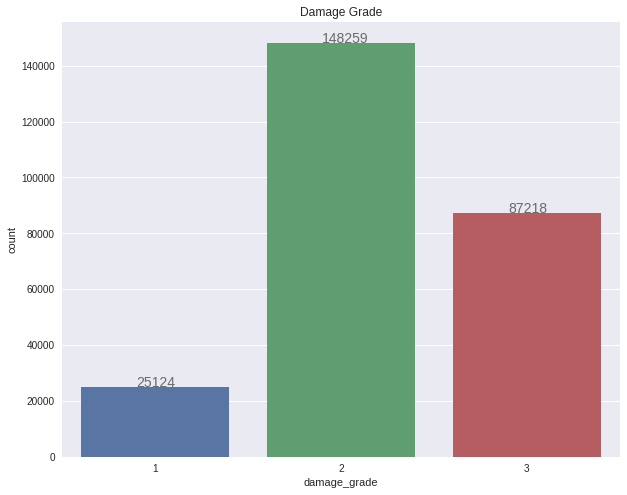

In [4]:
# checking the dependent variable --> `damage_grade`
plt.figure(figsize=(10,8))
ax=sns.countplot("damage_grade",data=train)
for i in ax.patches:
    # for the number text
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.3, i.get_height(), \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey')
plt.title("Damage Grade")
plt.show()  

## Model

In [5]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# copying the original dataset into X
X = train
# droping building_id and dependent variable damage_grade
X = X.drop(["damage_grade","building_id"],axis=1)
# dependent variable
y = train["damage_grade"]

# label encoding the categorical variables
label_encoding_columns=['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status']
# label encoding categorical columns in train dataset 
for i in label_encoding_columns:
    X[i]=X[i].astype("category")
    X[i]=X[i].cat.codes
# label encoding categorical columns in test dataset
for j in label_encoding_columns:
    test[j]=test[j].astype("category")
    test[j]=test[j].cat.codes

# Split data
x_train, x_test,y_train, y_test = train_test_split(X,y,test_size = 0.20,random_state = 42)

rf = RandomForestClassifier(n_estimators = 500,random_state = 1, max_depth=None,n_jobs=-1)
rf.fit(x_train,y_train)
rf_pred=rf.predict(x_test)

## Save & Load Model

In [ ]:
# from sklearn.externals import joblib

# joblib_file = "rf_model.pkl"

# Save Model
# joblib.dump(rf, joblib_file)

# # Load from file
# joblib_model = joblib.load(joblib_file)

# Calculate the accuracy and predictions
# score = joblib_model.score(x_test, y_test)
# print("Test score: {0:.2f} %".format(100 * score))
# Ypredict = joblib_model.predict(test)

## Result for Model

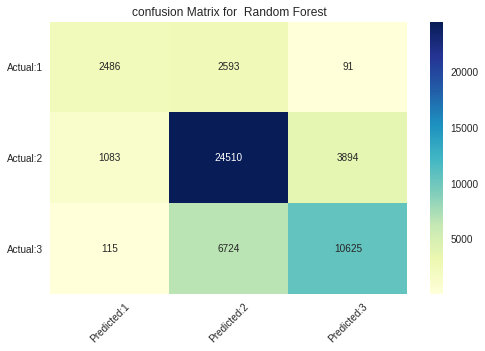

----------------------------------------------------------------------------------------------------
Accuracy Score for Random Forest : 0.7218011933769498
----------------------------------------------------------------------------------------------------


classification report for Random Forest :

               precision    recall  f1-score   support

           1       0.67      0.48      0.56      5170
           2       0.72      0.83      0.77     29487
           3       0.73      0.61      0.66     17464

    accuracy                           0.72     52121
   macro avg       0.71      0.64      0.67     52121
weighted avg       0.72      0.72      0.72     52121

----------------------------------------------------------------------------------------------------


In [6]:
# Confusion Matrix
cm=confusion_matrix(y_test,rf_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:1','Predicted:2','Predicted:3'],
                                         index=['Actual:1','Actual:2','Actual:3'])
                                                                            
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
plt.title("confusion Matrix for  Random Forest")
plt.xticks(rotation=45)
plt.yticks(rotation=360)
plt.show()

# Accuracy
print("-"*100)
print("Accuracy Score for Random Forest :",accuracy_score(y_test,rf_pred))
print("-"*100)
print("\n")
print("classification report for Random Forest :\n\n",classification_report(y_test, rf_pred))
print("-"*100)